In [1]:
from langchain_aws import ChatBedrockConverse
from langchain.schema import HumanMessage, SystemMessage
import boto3
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from opensearchpy import OpenSearch, RequestsHttpConnection
import os
import boto3
import json
import sys
from langchain.schema import BaseRetriever, Document
from typing import List, Optional, Dict, Tuple , TypedDict ,Annotated
from langchain_core.documents import Document
import fitz
import concurrent.futures
from langchain_aws import BedrockEmbeddings
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts.prompt import PromptTemplate
from operator import itemgetter
from langchain_core.runnables import RunnableLambda
from pydantic import BaseModel, Field ,ValidationError

import re
import requests
from bs4 import BeautifulSoup
from langchain.agents import tool
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles


In [2]:
#https://app.tavily.com/sign-in

In [3]:
bedrock_client = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-east-1'  # replace with your region
)
llm = ChatBedrockConverse(
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
    client=bedrock_client,
    temperature=0.7,
    max_tokens=2000
)

In [4]:
def visualize(graph):
    display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
    )

In [5]:
from langchain_core.messages import AIMessage, HumanMessage
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [6]:
#langraph의 핵심(state)
class State(TypedDict):
    # 메시지 정의(list type 이며 add_messages 함수를 사용하여 메시지를 추가)
    messages: Annotated[list, add_messages]

In [15]:
def chatbot(state: State) -> State:
    # print("check_point_1 -> ", state["messages"])

    messages = state["messages"]
    
    # Convert to format LLM expects if needed
    formatted_messages = []
    for msg in messages:
        if isinstance(msg, tuple):
            role, content = msg
            if role == "user":
                formatted_messages.append(HumanMessage(content=content))
            else:
                formatted_messages.append(AIMessage(content=content))
        else:
            formatted_messages.append(msg)
    
    response = llm.invoke(formatted_messages)
    
    # Return in tuple format
    return {"messages": [("assistant", response.content)]}



In [16]:
def chatbottwo(state: State) -> State:
    # print("check_point_2 -> ", state["messages"])
    
    # Get the last assistant message which should contain the top 10 list
    last_message = None
    for message in state["messages"]:
        # Check if it's a LangChain message object
        if hasattr(message, 'content') and hasattr(message, '__class__') and message.__class__.__name__ == 'AIMessage':
            last_message = message.content
        # Check if it's a tuple with role and content
        elif isinstance(message, tuple) and len(message) == 2 and message[0] == "assistant":
            last_message = message[1]
    
    if not last_message:
        return {"messages": [("assistant", "I don't have any recommendations to filter.")]}
    
    # Create a prompt to select top 3
    prompt_select_three = ChatPromptTemplate.from_template("""
    {information}
    
    이 정보를 바탕으로 10개의 리스트 중 가장 유명한 세개만 알려주세요
    """)
    
    # Create a chain
    chaintest = prompt_select_three | llm | StrOutputParser()
    
    # Get the top 3 recommendations
    top_three = chaintest.invoke({"information": last_message})
    
    # Return as a message - use the same format as your input
    # If you're using tuples when invoking the graph:
    return {"messages": [("assistant", top_three)]}

In [17]:
graph_builder = StateGraph(State)

#node 등록
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("chatbottwo", chatbottwo)


In [18]:
#node에서 어느 node로 갈지 등록 ( 예시 START -> chatbot -> chatbottwo -> end )
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", "chatbottwo")
graph_builder.add_edge("chatbottwo", END)


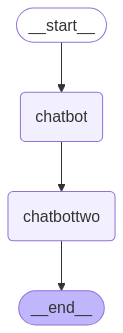

In [19]:
graph = graph_builder.compile()

visualize(graph)

In [20]:

question = "서울의 유명한 맛집 TOP 10 추천해줘"

response=graph.invoke({"messages": [("user", question)]})


In [21]:
response

{'messages': [HumanMessage(content='서울의 유명한 맛집 TOP 10 추천해줘', additional_kwargs={}, response_metadata={}, id='44ed6d33-85d5-4e3c-8b3f-2e9c3bae1602'),
  AIMessage(content='서울에는 정말 다양한 맛집들이 많습니다. 지역과 음식 종류를 고려해서 몇 가지 추천해드리겠습니다.\n\n1. 빈대떡 - 서래마을 옆 전통시장에 있는 유명한 핫플레이스. 빈대떡과 호떡이 맛있습니다.\n\n2. 한남동 교자바우 - 한남동에 위치한 맛있는 교자 전문점입니다. 직접 손으로 빚은 교자가 일품.\n\n3. 종로육고기 - 종로에 있는 60년 전통의 소고기 전문점. 육회비빔밥이 가장 유명합니다. \n\n4. 노량진 수산시장 - 활어회 전문점들이 많은 곳으로, 싱싱한 회를 맛볼 수 있습니다.\n\n5. 압구정 치치 - 이탈리아 출신 셰프의 정통 나폴리 피자를 맛볼 수 있습니다.\n\n6. 통인시장 순대골목 - 전통 있는 순대골목에서 싸고 맛있는 순대를 즐길 수 있죠.\n\n7. 낙산공원 호호식당 - 낙산공원 인근에 위치한 오래된 한식당으로 전복죽이 유명합니다.\n\n8. 을지로 맷돼지 - 을지로의 대표 맷돼지 전문점으로 직화구이 맛이 일품입니다.\n\n9. 동교동 존스토너 - 동교동에 위치한 미국 셰프의 정통 바베큐 전문점입니다.  \n\n10. 홍대입구 망치갈비 - 홍대 근처에서 젊은 사람들에게 인기 있는 갈비전문점입니다.\n\n다양한 분야의 맛집들을 추천해드렸는데 관심 있는 곳이 있다면 더 자세히 알려드릴게요.', additional_kwargs={}, response_metadata={}, id='af03db91-248f-4d10-a509-88b8bb54d901'),
  AIMessage(content='제가 추천한 10개의 맛집 중에서 가장 유명한 세 곳은 다음과 같습니다:\n\n1. 빈대떡 - 서래마을 옆 전통시장에 있는 유명한 핫플레이스로, 빈대떡과 

In [22]:
question = "서울의 유명한 관광명소 TOP 10 추천해줘"

# Stream the graph execution using tuples
for event in graph.stream({"messages": [("user", question)]}):
    # Get the node name and state
    node_name = list(event.keys())[0]
    state = list(event.values())[0]
    
    print(f"Node: {node_name}")
    print("-" * 50)
    
    # Display the last message from this node
    if state["messages"] and len(state["messages"]) > 0:
        last_message = state["messages"][-1]
        
        # Handle different message formats
        if hasattr(last_message, 'content'):
            # It's a LangChain message object
            role = last_message.__class__.__name__.replace('Message', '')
            content = last_message.content
        elif isinstance(last_message, tuple) and len(last_message) == 2:
            # It's a tuple of (role, content)
            role, content = last_message
        else:
            # Unknown format, just print the message
            print(f"Message: {last_message}")
            continue
        
        # Print the full content
        print(f"{role}: {content}")
    
    print("-" * 50)
    print()  # Add an extra line for better readability


Node: chatbot
--------------------------------------------------
assistant: 서울은 역사와 문화가 살아 숨쉬는 매력적인 도시입니다. 서울의 대표 관광명소 TOP 10을 소개해 드리겠습니다.

1. 경복궁 - 조선시대 왕궁으로 아름다운 궁궐 건축물과 정원을 감상할 수 있습니다.

2. 남산 서울타워 - 서울의 상징적인 곳으로 전망대에서 서울 시내 전경을 한눈에 볼 수 있습니다. 

3. 인사동 - 전통 문화가 살아있는 거리로 갤러리, 공방, 전통 체험 등을 즐길 수 있습니다.

4. 북촌한옥마을 - 고궁 근처에 자리한 한옥마을로 전통 가옥과 골목길 산책이 매력적입니다.

5. 동대문디자인플라자(DDP) - 현대적인 건축물로 전시, 공연 등 다양한 문화행사가 열립니다.

6. 청계천 - 서울 도심을 가로지르는 하천으로 산책로와 야경이 아름답습니다.

7. 국립중앙박물관 - 한국의 역사와 문화를 한눈에 살펴볼 수 있는 대표 박물관입니다.  

8. 남산공원 - 도심 속 자연 공원으로 산책로와 전망대가 인기 있습니다.

9. 이태원 - 다양한 외국 문화를 체험할 수 있는 거리로 각국 음식과 상점이 있습니다.

10. 홍대앞 거리 - 젊음의 거리로 클럽, 공연장, 상점 등 다양한 즐길 거리가 있습니다.

이렇게 역사와 전통, 현대 문화를 모두 경험할 수 있는 매력적인 관광지들이 많은 서울에서 좋은 추억 만드시기 바랍니다.
--------------------------------------------------

Node: chatbottwo
--------------------------------------------------
assistant: 서울의 대표 관광명소 TOP 10 중에서 가장 유명한 세 곳은 다음과 같습니다:

1. 경복궁
2. 남산 서울타워  
3. 인사동

경복궁은 조선시대 왕궁으로 아름다운 궁궐 건축물과 정원을 자랑하며, 서울을 대표하는 역사 유적지입니다.

남산 서울타워는 서울의 상